## 1. VoxelMorph on neurite-OASIS demo

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [ ]:
pip install tensorflow==2.10 keras==2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

In [ ]:
# install voxelmorph
!git clone https://github.com/voxelmorph/voxelmorph.git # getting vxm from git to use scripts
!pip install neurite # dependencies

fatal: destination path 'voxelmorph' already exists and is not an empty directory.


In [ ]:
# import voxelmorph
import sys
sys.path.append('voxelmorph')
import voxelmorph as vxm

## 2. VoxelMorph 구현하기

In [ ]:
!pip install voxelmorph

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 5.6 MB/s eta 0:00:00
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19533 sha256=4fc0a4b7a98b449d47af69bdf80bd022a03e82347b14b4c42d99136f8c292686
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [ ]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne

print(f"TensorFlow Version: {tf.__version__}")
print(f"VoxelMorph: {vxm}")
print(f"Neurite: {ne}")

TensorFlow Version: 2.10.0
VoxelMorph: <module 'voxelmorph' from '/usr/local/lib/python3.10/dist-packages/voxelmorph/__init__.py'>
Neurite: <module 'neurite' from '/usr/local/lib/python3.10/dist-packages/neurite/__init__.py'>


In [ ]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

--2025-01-12 08:19:05--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16644702 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15.87M  28.1MB/s    in 0.6s    

2025-01-12 08:19:06 (28.1 MB/s) - ‘data.tar.gz’ saved [16644702/16644702]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
fs_rgb.npy
subj1.npz
subj2.npz
tutorial_data.npz


In [ ]:
npz = np.load('tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


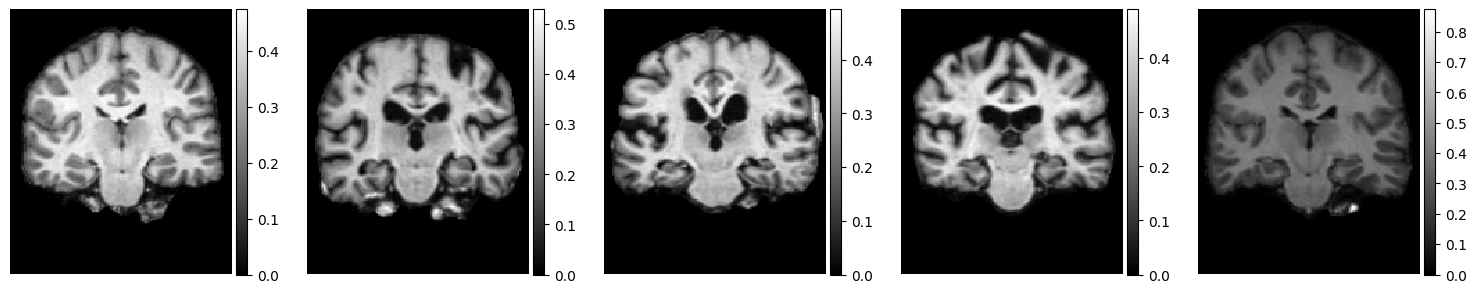

In [ ]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

### Modeling By VoxelMorph

In [ ]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

In [ ]:
# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

In [ ]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)

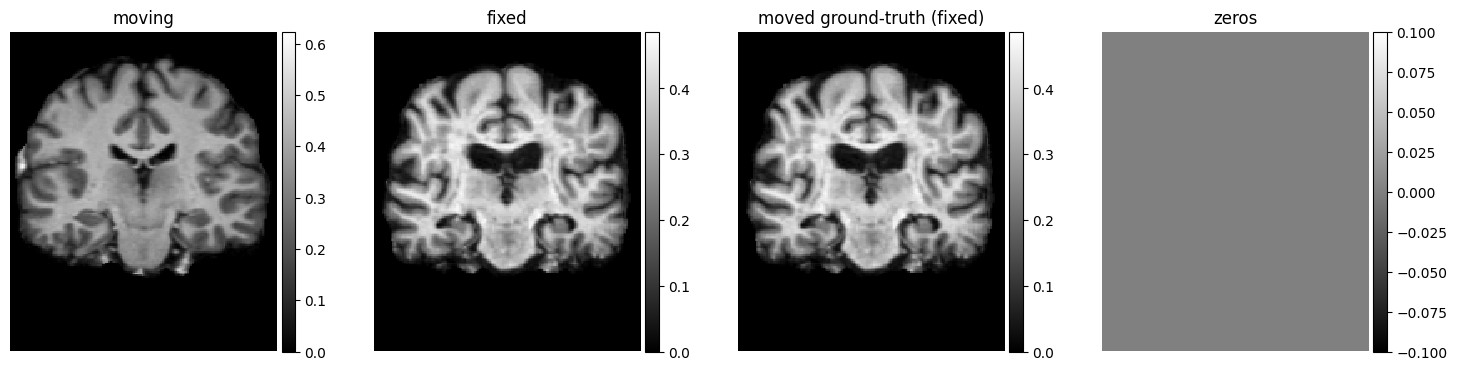

In [ ]:
# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);

<ipython-input-42-2a3595386513>:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);


Epoch 1/5
5/5 - 21s - loss: 0.0073 - vxm_dense_transformer_loss: 0.0073 - vxm_dense_flow_loss: 2.8142e-08 - 21s/epoch - 4s/step
Epoch 2/5
5/5 - 16s - loss: 0.0075 - vxm_dense_transformer_loss: 0.0075 - vxm_dense_flow_loss: 2.8705e-07 - 16s/epoch - 3s/step
Epoch 3/5
5/5 - 16s - loss: 0.0070 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 1.1211e-06 - 16s/epoch - 3s/step
Epoch 4/5
5/5 - 23s - loss: 0.0071 - vxm_dense_transformer_loss: 0.0071 - vxm_dense_flow_loss: 3.5546e-06 - 23s/epoch - 5s/step
Epoch 5/5
5/5 - 26s - loss: 0.0064 - vxm_dense_transformer_loss: 0.0064 - vxm_dense_flow_loss: 9.9766e-06 - 26s/epoch - 5s/step


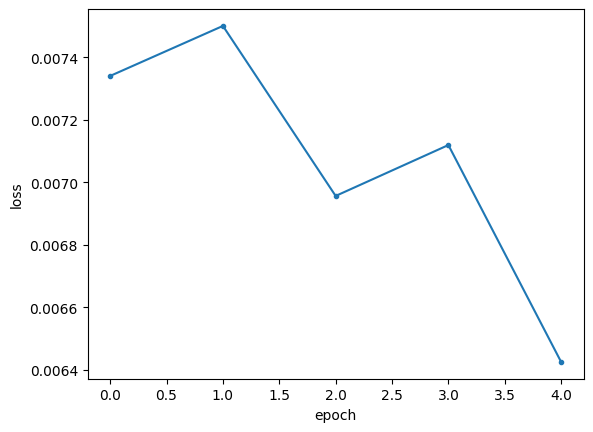

In [ ]:
# as before, let's visualize what happened
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

In [ ]:
# load pretrained model weights
vxm_model.load_weights('brain_2d_smooth.h5')

In [ ]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [ ]:
# prediction
val_pred = vxm_model.predict(val_input)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


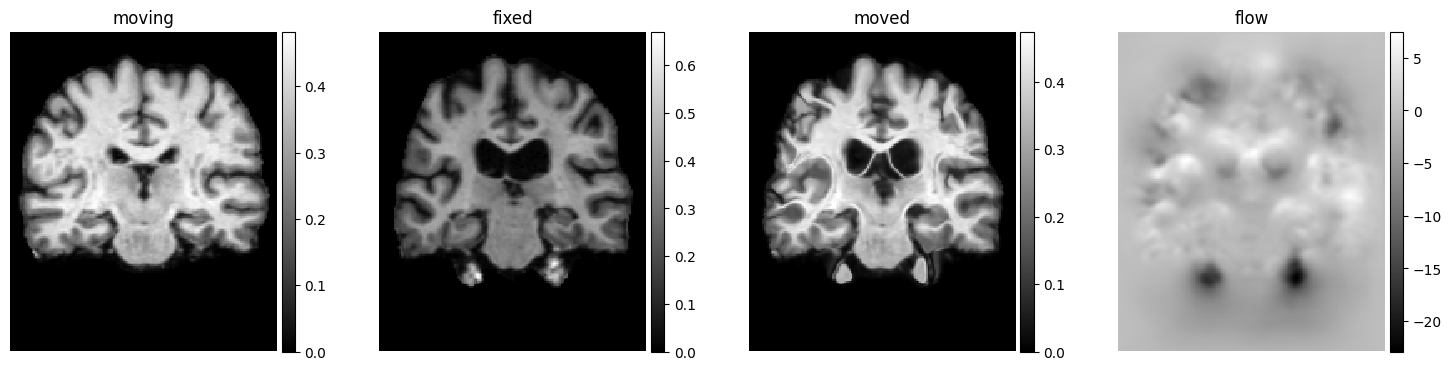

In [ ]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
# prediction from model with MSE + smoothness loss
vxm_model.load_weights('brain_2d_smooth.h5')
our_val_pred = vxm_model.predict(val_input)

# prediction from model with just MSE loss
vxm_model.load_weights('brain_2d_no_smooth.h5')
mse_val_pred = vxm_model.predict(val_input)

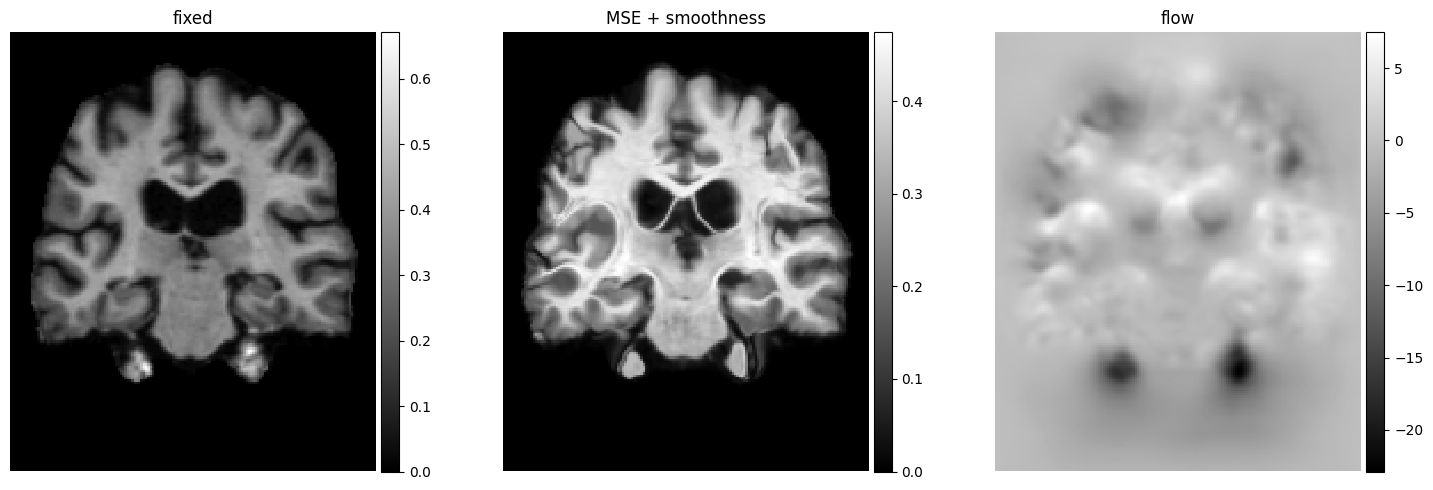

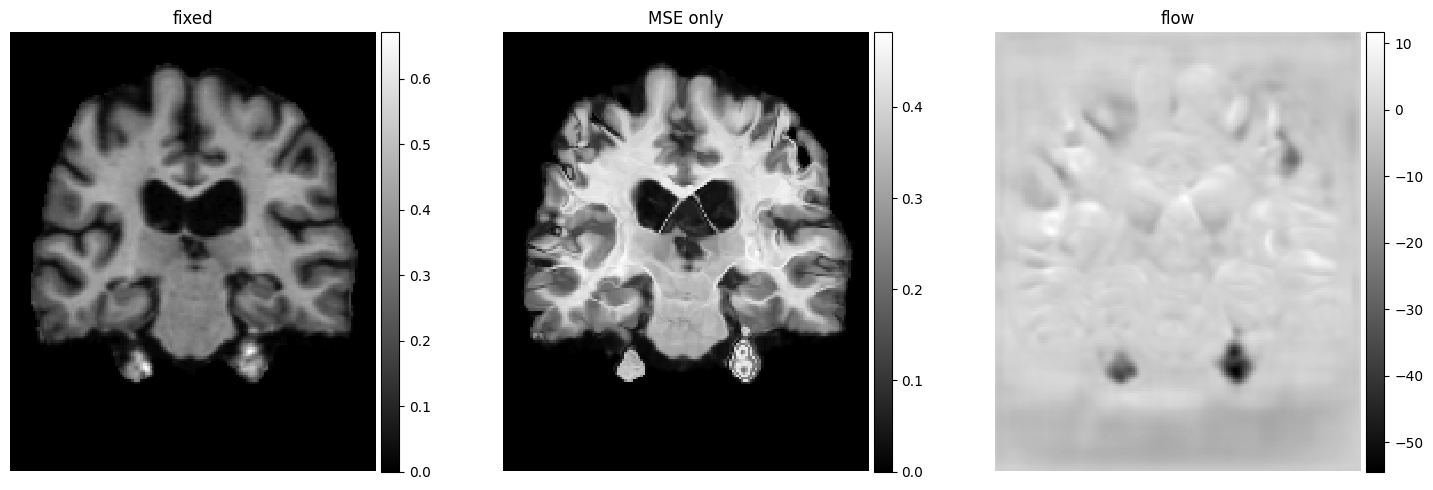

In [ ]:
# visualize MSE + smoothness model output
images = [img[0, ..., 0] for img in [val_input[1], *our_val_pred]]
titles = ['fixed', 'MSE + smoothness', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# visualize MSE model output
images = [img[0, ..., 0] for img in [val_input[1], *mse_val_pred]]
titles = ['fixed', 'MSE only', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

### 1. U-Net 네트워크

> 변형 필드를 생성하기 위한 CNN 아키텍쳐

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=2):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(nn.Conv3d(in_channels, 16, kernel_size=3, padding=1), nn.ReLU(inplace=True))
        self.enc2 = nn.Sequential(nn.Conv3d(16, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True))
        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv3d(32, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True))
        # Decoder
        self.dec1 = nn.Sequential(nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2), nn.ReLU(inplace=True))
        self.dec2 = nn.Sequential(nn.ConvTranspose3d(32, out_channels, kernel_size=2, stride=2))
    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.bottleneck(x2)
        x4 = self.dec1(x3)
        x5 = self.dec2(x4)
        return x5

### 2. Spatial Transforer Layer

> 이동 이미지(M)을 변형 필드를 활용하여 변형!!

In [ ]:
class SpatialTransformer(nn.Module):
    def __init__(self):
        super(SpatialTransformer, self).__init__()

    def forward(self, moving_image, flow):
         # flow: 변형 필드 (BxDxHxWx3)
        _, D, H, W = moving_image.shape[1:]
        grid = torch.meshgrid(torch.arange(D), torch.arange(H), torch.arange(W))
        grid = torch.stack(grid, dim=-1).float().to(flow.device)
        grid = grid.unsqueeze(0).expand(flow.shape[0], *grid.shape)
        grid = grid + flow  # Apply transformation
        grid = 2.0 * grid / torch.tensor([D-1, H-1, W-1]).to(flow.device) - 1.0
        return nn.functional.grid_sample(moving_image, grid, align_corners=True)

### 3. 손실 함수 2가지

In [ ]:
## 1. 유사성 손실
def similarity_loss(fixed_image, moved_image, loss_type='mse'):
    if loss_type == 'mse':
        return nn.MSELoss()(fixed_image, moved_image)
    elif loss_type == 'cc':
        # Cross-Correlation loss
        mean_fixed = fixed_image.mean()
        mean_moved = moved_image.mean()
        numerator = ((fixed_image - mean_fixed) * (moved_image - mean_moved)).mean()
        denominator = (fixed_image - mean_fixed).pow(2).mean() * (moved_image - mean_moved).pow(2).mean()
        return -numerator / torch.sqrt(denominator)

## 2. 정규화 손
def smoothness_loss(flow):
    return torch.mean(torch.abs(flow[:, :, :, :-1] - flow[:, :, :, 1:]))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# 데이터셋 클래스 정의
class VoxelMorphDataset(Dataset):
    def __init__(self, x_data):
        self.x_data = x_data
        self.vol_shape = x_data.shape[1:]

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        moving_idx = np.random.randint(0, len(self.x_data))
        fixed_idx = np.random.randint(0, len(self.x_data))
        moving_image = torch.tensor(self.x_data[moving_idx], dtype=torch.float32).unsqueeze(0)
        fixed_image = torch.tensor(self.x_data[fixed_idx], dtype=torch.float32).unsqueeze(0)
        zero_phi = torch.zeros((*self.vol_shape, len(self.vol_shape)), dtype=torch.float32)
        return moving_image, fixed_image, zero_phi

# 데이터 로드
batch_size = 8
train_dataset = VoxelMorphDataset(x_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# UNet 및 SpatialTransformer 초기화
unet = UNet(in_channels=2, out_channels=len(x_train.shape[1:]))
spatial_transformer = SpatialTransformer()

# 손실 함수 및 옵티마이저 정의
optimizer = optim.Adam(unet.parameters(), lr=1e-4)

def similarity_loss(fixed_image, moved_image):
    return nn.MSELoss()(fixed_image, moved_image)

def smoothness_loss(flow):
    return torch.mean(torch.abs(flow[:, :, :-1] - flow[:, :, 1:]))

# 학습 루프
num_epochs = 50

for epoch in range(num_epochs):
    unet.train()
    epoch_loss = 0.0

    for moving_image, fixed_image, zero_phi in train_loader:
        moving_image, fixed_image, zero_phi = (
            moving_image.to('cuda'),
            fixed_image.to('cuda'),
            zero_phi.to('cuda'),
        )

        # UNet을 사용해 변형 필드 생성
        flow = unet(torch.cat([moving_image, fixed_image], dim=1))

        # 변형 필드를 SpatialTransformer에 적용하여 이동 이미지 생성
        moved_image = spatial_transformer(moving_image, flow)

        # 손실 계산
        sim_loss = similarity_loss(fixed_image, moved_image)
        smooth_loss = smoothness_loss(flow)
        total_loss = sim_loss + 0.01 * smooth_loss

        # 최적화
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx